In [22]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import glob, os

# 앨범 이미지를 불러와서 시대별로 나누기
# 1990년대 : 0
# 2000년대 : 1
# 2010년대 : 2

# 일부 이미지 3채널이 아니라 1채널(GrayScale)임
# 우선
filepath = './album/'
imgList = glob.glob(filepath+"*")
yearLabel = {'9': 0,
             '0': 1,
             '1': 2}

imgdata = []
eraLabel = []

for path_ in imgList:
    img = Image.open(path_)

    # RGB 일 때
    img = np.array(img).reshape(-1)
    if len(img) == 6912:
        imgdata.append(img)

        era = path_.split('/')[-1].split('_')[1][2]
        eraLabel.append(yearLabel[era])

    # # gray scale 일 때 사용
    # img = img.convert('L')
    # img = np.array(img).reshape(-1)
    # if len(img) == 2304:
    #     imgdata.append(img)
    #     era = path_.split('/')[-1].split('_')[1][2]
    #     eraLabel.append(yearLabel[era])


imgdata = np.array(imgdata).reshape((-1,48,48,3))
eraLabel = np.array(eraLabel)

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization,Activation,LeakyReLU,Conv2D,MaxPooling2D,AveragePooling2D,Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.utils import to_categorical
from keras.utils import plot_model

# 정규화 및 원핫인코딩
imgdata = imgdata.astype('float32')/255.0
eraLabel = to_categorical(eraLabel).astype(int)

# 모델 생성
folderpath = './models/'
if not os.path.exists(folderpath):
    os.makedirs(folderpath)
    print('models 폴더 생성 완료')

In [ ]:
cnn = Sequential(name='CNN_BatchNormalization_padding_same')

cnn.add(Conv2D(64,kernel_size=3,input_shape=(48,48,3),activation='relu',kernel_initializer='he_normal',padding='same'))
cnn.add(Conv2D(64,kernel_size=3,kernel_initializer='he_normal',padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(padding='same'))

# cnn.add(Conv2D(128,kernel_size=3,kernel_initializer='he_normal',padding='same'))
# cnn.add(Conv2D(128,kernel_size=3,kernel_initializer='he_normal',padding='same'))
# cnn.add(BatchNormalization())
# cnn.add(Activation('relu'))

cnn.add(Conv2D(128,kernel_size=3,kernel_initializer='he_normal',padding='same'))
cnn.add(Conv2D(128,kernel_size=3,kernel_initializer='he_normal',padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(256,kernel_size=3,kernel_initializer='he_normal',padding='same'))
cnn.add(Conv2D(256,kernel_size=3,kernel_initializer='he_normal',padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D())

cnn.add(Flatten())

cnn.add(Dense(256,kernel_initializer='he_normal'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))

cnn.add(Dense(3,activation='softmax'))

plot_model(cnn,to_file=f'{folderpath}{cnn.name}.png',show_layer_names=True,show_layer_activations=True,show_shapes=True)

In [45]:
from keras.optimizers import Adam,nadam
erCB = EarlyStopping(verbose=1,patience=20,monitor='val_accuracy')
mcCB = ModelCheckpoint(folderpath+f"{cnn.name}.hdf5",save_best_only=True,monitor='val_accuracy',verbose=1)
# def scheduler(epoch,lr=0.01):
#     if epoch % 10 == 0:
#         return lr * np.math.exp(-0.1)
#     else:
#         return lr
# lrCB = LearningRateScheduler(schedule=scheduler)

cnn.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.01),
            metrics=['accuracy'])

history = cnn.fit(imgdata,eraLabel,batch_size=16,epochs=50,
        validation_split=0.1,
            callbacks=[erCB,mcCB],

        )



# 검증셋과 학습셋의 오차를 저장
y_vAcc = history.history['val_accuracy']
y_Acc = history.history['accuracy']

# 그래프로 표현해 봅니다
x_len = np.arange(len(y_Acc))
plt.plot(x_len,y_vAcc,marker='.',c='red',label='Test_acc')
plt.plot(x_len,y_Acc,marker='.',c='blue',label='Train_acc')

# 그래프에 그리드를 주고 레이블 표시
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig(f'././image/CNN_{cnn.name}_acc.jpg')
plt.show()


# 검증셋과 학습셋의 오차를 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다
x_len = np.arange(len(y_Acc))
plt.plot(x_len,y_vloss,marker='.',c='red',label='Test_loss')
plt.plot(x_len,y_loss,marker='.',c='blue',label='Train_loss')

# 그래프에 그리드를 주고 레이블 표시
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(f'././image/CNN_{cnn.name}_loss.jpg')
plt.show()

Epoch 1/50
165/166 [============================>.] - ETA: 0s - loss: 1.0998 - accuracy: 0.3201
Epoch 1: val_accuracy improved from -inf to 0.32993, saving model to ./models/CNN_BatchNormalization_padding_same.hdf5
166/166 [==============================] - 31s 182ms/step - loss: 1.0998 - accuracy: 0.3197 - val_loss: 1.0987 - val_accuracy: 0.3299
Epoch 2/50
165/166 [============================>.] - ETA: 0s - loss: 1.0995 - accuracy: 0.3307
Epoch 2: val_accuracy did not improve from 0.32993
166/166 [==============================] - 31s 186ms/step - loss: 1.0995 - accuracy: 0.3303 - val_loss: 1.0994 - val_accuracy: 0.3265
Epoch 3/50
165/166 [============================>.] - ETA: 0s - loss: 1.1001 - accuracy: 0.3333
Epoch 3: val_accuracy did not improve from 0.32993
166/166 [==============================] - 31s 188ms/step - loss: 1.1001 - accuracy: 0.3330 - val_loss: 1.0991 - val_accuracy: 0.3299
Epoch 4/50
166/166 [==============================] - ETA: 0s - loss: 1.0995 - accuracy: 

KeyboardInterrupt: 

In [24]:
def imgResize(filepath, size):
    from PIL import Image

    img = np.array(Image.open(filepath)).reshape(-1)
    img = img.reshape(size)/255.0

    return img.reshape((-1,48,48,3))


from keras.applications import InceptionResNetV2
InceptionResNetV2()

Epoch 1/1000
146/147 [============================>.] - ETA: 0s - loss: 1.4691 - accuracy: 0.3378
Epoch 1: val_accuracy improved from -inf to 0.41327, saving model to ./models/ResNet50_Dense_add.hdf5
147/147 [==============================] - 11s 66ms/step - loss: 1.4677 - accuracy: 0.3380 - val_loss: 1.1055 - val_accuracy: 0.4133 - lr: 9.0484e-04
Epoch 2/1000
147/147 [==============================] - ETA: 0s - loss: 1.2758 - accuracy: 0.3614
Epoch 2: val_accuracy did not improve from 0.41327
147/147 [==============================] - 10s 68ms/step - loss: 1.2758 - accuracy: 0.3614 - val_loss: 1.0861 - val_accuracy: 0.4031 - lr: 9.0484e-04
Epoch 3/1000
147/147 [==============================] - ETA: 0s - loss: 1.2296 - accuracy: 0.3542
Epoch 3: val_accuracy did not improve from 0.41327
147/147 [==============================] - 8s 58ms/step - loss: 1.2296 - accuracy: 0.3542 - val_loss: 1.0629 - val_accuracy: 0.4116 - lr: 9.0484e-04
Epoch 4/1000
147/147 [==============================]

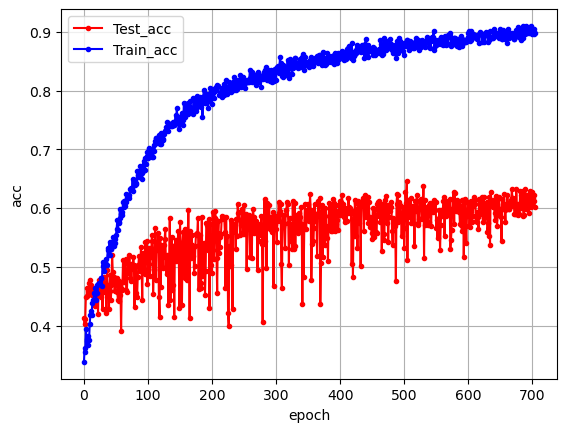

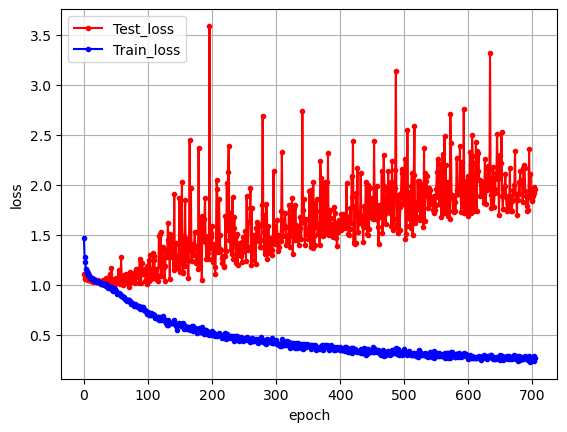

In [49]:
from keras.applications import ResNet50
transfer_model = ResNet50(weights='imagenet',include_top=False, input_shape=(48,48,3))
transfer_model.trainable = False

finietune_model = Sequential(name='ResNet50_Dense_add')
finietune_model.add(transfer_model)
finietune_model.add(Flatten())
finietune_model.add(Dense(64,kernel_initializer='he_normal'))
finietune_model.add(BatchNormalization())
finietune_model.add(Activation('relu'))
finietune_model.add(Dropout(0.5))
finietune_model.add(Dense(64,kernel_initializer='he_normal'))
finietune_model.add(BatchNormalization())
finietune_model.add(Activation('relu'))
finietune_model.add(Dropout(0.5))
finietune_model.add(Dense(64,kernel_initializer='he_normal'))
finietune_model.add(BatchNormalization())
finietune_model.add(Activation('relu'))
finietune_model.add(Dropout(0.5))
finietune_model.add(Dense(3,activation='softmax'))

plot_model(finietune_model,to_file=f'{folderpath}{finietune_model.name}.png',show_layer_names=True,show_layer_activations=True,show_shapes=True)

erCB = EarlyStopping(verbose=1,patience=200,monitor='val_accuracy')
mcCB = ModelCheckpoint(folderpath+f"{finietune_model.name}.hdf5",save_best_only=True,monitor='val_accuracy',verbose=1)

def scheduler(epoch,lr=0.1):
    if epoch % 100 == 0:
        return lr * np.math.exp(-0.1)
    else:
        return lr
lrCB = LearningRateScheduler(schedule=scheduler)

finietune_model.compile(loss='categorical_crossentropy',optimizer='adam',
            metrics=['accuracy'])

history = finietune_model.fit(imgdata,eraLabel,batch_size=16,epochs=1000,
        validation_split=0.2,
        callbacks=[erCB,mcCB,lrCB])



# 검증셋과 학습셋의 오차를 저장
y_vAcc = history.history['val_accuracy']
y_Acc = history.history['accuracy']

# 그래프로 표현해 봅니다
x_len = np.arange(len(y_Acc))
plt.plot(x_len,y_vAcc,marker='.',c='red',label='Test_acc')
plt.plot(x_len,y_Acc,marker='.',c='blue',label='Train_acc')

# 그래프에 그리드를 주고 레이블 표시
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig(f'././image/{finietune_model.name}_acc.jpg')
plt.show()


# 검증셋과 학습셋의 오차를 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다
x_len = np.arange(len(y_Acc))
plt.plot(x_len,y_vloss,marker='.',c='red',label='Test_loss')
plt.plot(x_len,y_loss,marker='.',c='blue',label='Train_loss')

# 그래프에 그리드를 주고 레이블 표시
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(f'././image/{finietune_model.name}_loss.jpg')
plt.show()